# HR Analytics: Model Training & Evaluation

Notebook này thực hiện training và evaluation các models.

## Mục tiêu:
1. Load processed data
2. Train multiple models
3. Evaluate và compare models
4. Visualize results
5. Select best model

In [1]:
# Cell 1: Import và load data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')

from models import LogisticRegression, NaiveBayes, KNearestNeighbors, ModelEvaluator
from visualization import DataVisualizer

# Load processed data
X_train = np.load('../data/processed/X_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (15327, 11)
Test set: (3831, 11)



=== TRAINING LOGISTIC REGRESSION ===

Iteration 100/1000, Loss: 0.5627
Iteration 200/1000, Loss: 0.5338
Iteration 300/1000, Loss: 0.5224
Iteration 400/1000, Loss: 0.5160
Iteration 500/1000, Loss: 0.5119
Iteration 600/1000, Loss: 0.5091
Iteration 700/1000, Loss: 0.5072
Iteration 800/1000, Loss: 0.5059
Iteration 900/1000, Loss: 0.5049
Iteration 1000/1000, Loss: 0.5043


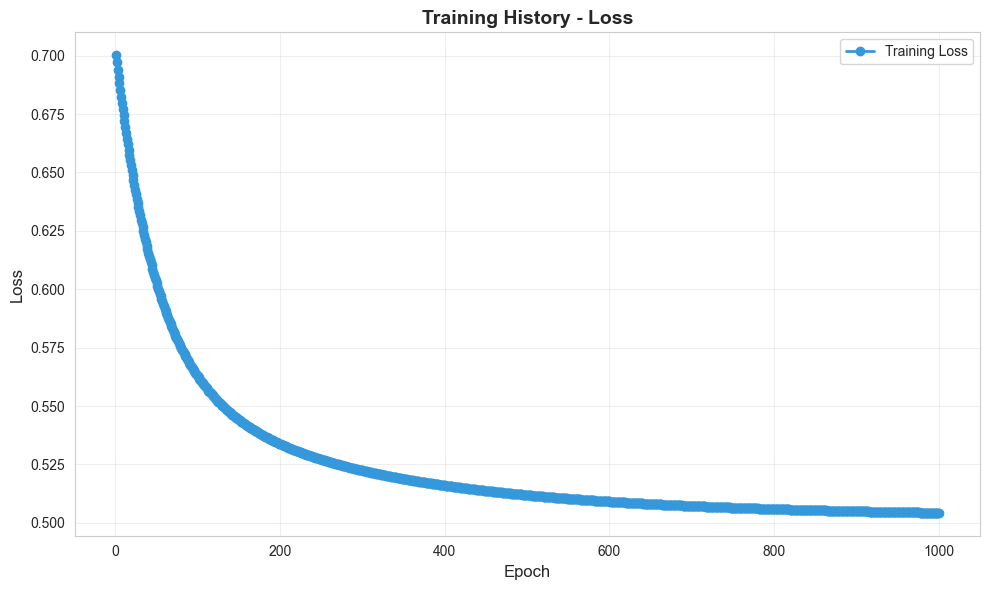

Logistic Regression trained


In [2]:
# Cell 2: Train Logistic Regression
print("\n=== TRAINING LOGISTIC REGRESSION ===\n")

lr_model = LogisticRegression(
    learning_rate=0.01,
    n_iterations=1000,
    regularization='l2',
    lambda_reg=0.01,
    random_state=42
)

lr_model.fit(X_train, y_train, verbose=True)

# Visualize training history
visualizer = DataVisualizer()
fig = visualizer.plot_training_history(lr_model.losses)
plt.show()

# Predict
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)

print("Logistic Regression trained")

In [3]:
# Cell 3: Train Naive Bayes
print("\n=== TRAINING NAIVE BAYES ===\n")

nb_model = NaiveBayes()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)
y_pred_proba_nb = nb_model.predict_proba(X_test)[:, 1]

print("Naive Bayes trained")


=== TRAINING NAIVE BAYES ===

Naive Bayes trained


In [4]:
# Cell 4: Train KNN
print("\n=== TRAINING KNN ===\n")

# Train multiple k values
k_values = [3, 5, 7, 9]
knn_models = {}

for k in k_values:
    print(f"Training KNN with k={k}...")
    knn = KNearestNeighbors(k=k, metric='euclidean')
    knn.fit(X_train, y_train)
    knn_models[k] = knn

# Use k=5 for comparison
knn_model = knn_models[5]
y_pred_knn = knn_model.predict(X_test)

print("KNN trained")


=== TRAINING KNN ===

Training KNN with k=3...
Training KNN with k=5...
Training KNN with k=7...
Training KNN with k=9...
KNN trained


In [5]:
# Cell 5: Evaluate all models
print("\n=== MODEL EVALUATION ===\n")

evaluator = ModelEvaluator()

models_results = {
    'Logistic Regression': {
        'y_pred': y_pred_lr,
        'y_pred_proba': y_pred_proba_lr
    },
    'Naive Bayes': {
        'y_pred': y_pred_nb,
        'y_pred_proba': y_pred_proba_nb
    },
    'KNN (k=5)': {
        'y_pred': y_pred_knn,
        'y_pred_proba': None
    }
}

print(f"{'Model':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
print("="*97)

for model_name, results in models_results.items():
    y_pred = results['y_pred']
    y_pred_proba = results['y_pred_proba']
    
    acc = evaluator.accuracy(y_test, y_pred)
    prec = evaluator.precision(y_test, y_pred)
    rec = evaluator.recall(y_test, y_pred)
    f1 = evaluator.f1_score(y_test, y_pred)
    
    if y_pred_proba is not None:
        auc = evaluator.roc_auc_score(y_test, y_pred_proba)
        print(f"{model_name:<25} {acc:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f} {auc:<12.4f}")
    else:
        print(f"{model_name:<25} {acc:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f} {'N/A':<12}")



=== MODEL EVALUATION ===

Model                     Accuracy     Precision    Recall       F1-Score     ROC-AUC     
Logistic Regression       0.7580       0.5415       0.1712       0.2602       0.7029      
Naive Bayes               0.7617       0.5255       0.4223       0.4683       0.7191      
KNN (k=5)                 0.7390       0.4678       0.3666       0.4111       N/A         



=== CONFUSION MATRICES ===



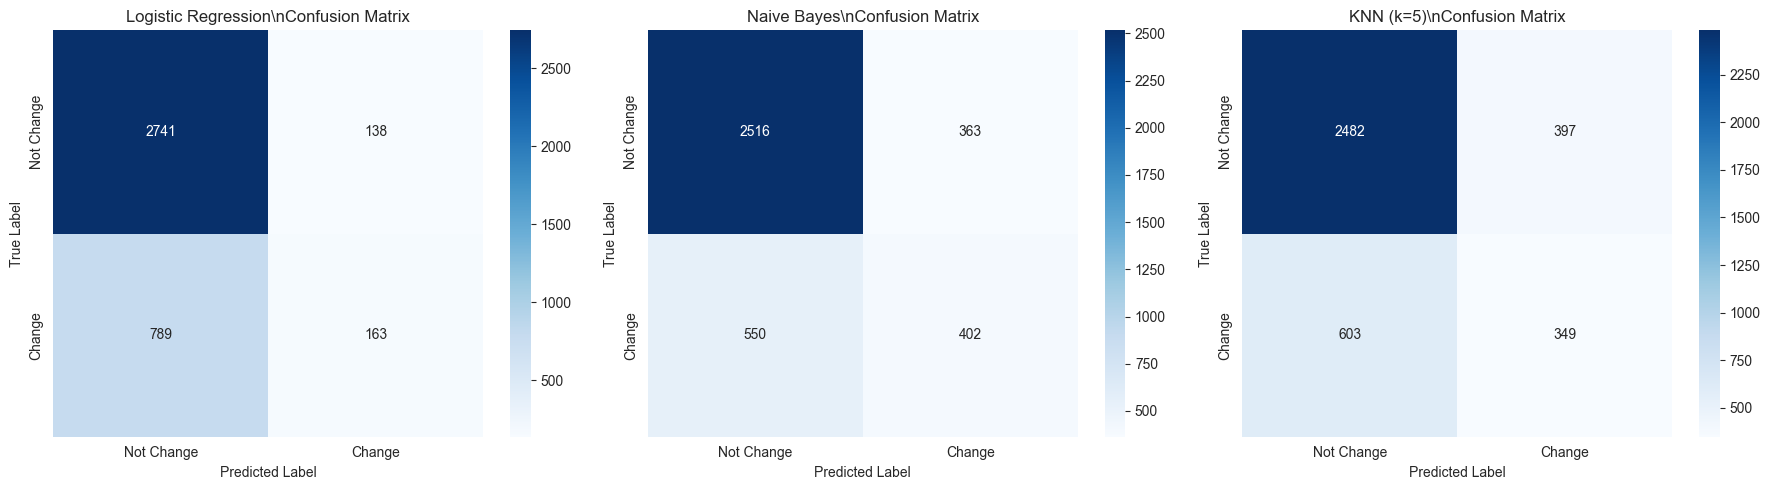

In [6]:
# Cell 6: Confusion matrices
print("\n=== CONFUSION MATRICES ===\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, results) in enumerate(models_results.items()):
    cm = evaluator.confusion_matrix(y_test, results['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Change', 'Change'],
                yticklabels=['Not Change', 'Change'])
    axes[idx].set_title(f'{model_name}\\nConfusion Matrix')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


=== ROC CURVES ===



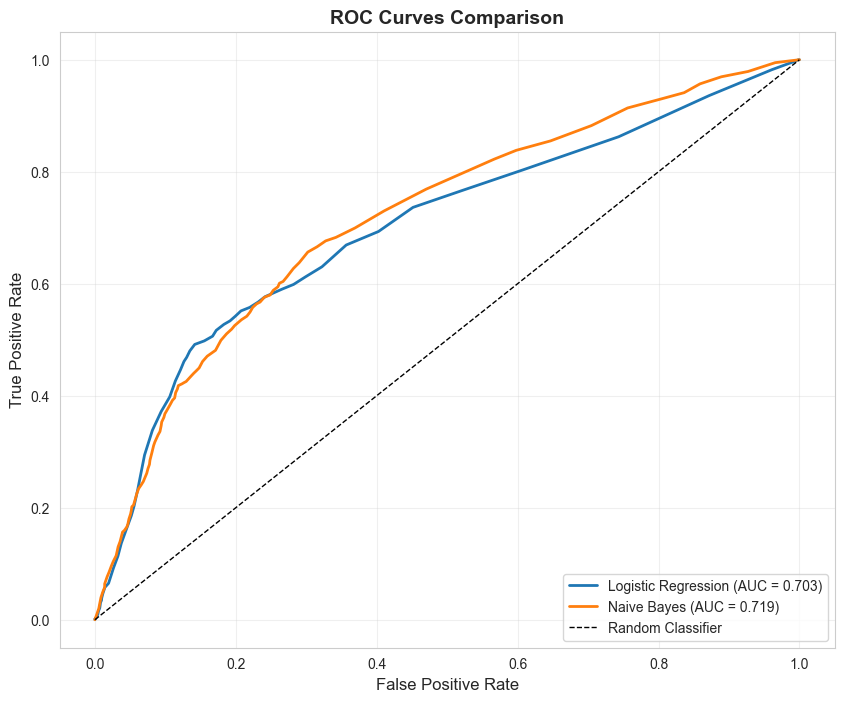

In [7]:
# Cell 7: ROC curves
print("\n=== ROC CURVES ===\n")

fig, ax = plt.subplots(figsize=(10, 8))

for model_name, results in models_results.items():
    if results['y_pred_proba'] is not None:
        y_pred_proba = results['y_pred_proba']
        
        # Calculate ROC
        thresholds = np.linspace(0, 1, 100)
        tpr_list = []
        fpr_list = []
        
        for threshold in thresholds:
            y_pred_thresh = (y_pred_proba >= threshold).astype(int)
            
            tp = np.sum((y_test == 1) & (y_pred_thresh == 1))
            fp = np.sum((y_test == 0) & (y_pred_thresh == 1))
            tn = np.sum((y_test == 0) & (y_pred_thresh == 0))
            fn = np.sum((y_test == 1) & (y_pred_thresh == 0))
            
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            tpr_list.append(tpr)
            fpr_list.append(fpr)
        
        # Calculate AUC
        auc = evaluator.roc_auc_score(y_test, y_pred_proba)
        
        # Plot
        ax.plot(fpr_list, tpr_list, linewidth=2, 
                label=f'{model_name} (AUC = {auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.show()

In [8]:
# Cell 8: Cross-validation
print("\n=== CROSS-VALIDATION ===\n")

lr_cv = LogisticRegression(learning_rate=0.01, n_iterations=500, random_state=42)
cv_scores = evaluator.cross_validate(lr_cv, X_train, y_train, k_folds=5, metric='f1')

print(f"Logistic Regression 5-Fold CV:")
print(f"  Scores: {cv_scores}")
print(f"  Mean F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")


=== CROSS-VALIDATION ===

Logistic Regression 5-Fold CV:
  Scores: [0.07635468 0.06396064 0.08060453 0.07125891 0.05778894]
  Mean F1: 0.0700 (+/- 0.0082)


In [9]:
# Cell 9: Feature importance (for Logistic Regression)
print("\n=== FEATURE IMPORTANCE ===\n")

# Load feature names
with open('../data/processed/feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f]

# Get coefficients from Logistic Regression
importances = np.abs(lr_model.weights)

# Visualize
fig = visualizer.plot_feature_importance(importances, feature_names, top_n=15)
plt.show()

# Print top features
sorted_idx = np.argsort(importances)[::-1]
print("Top 10 most important features:")
for i, idx in enumerate(sorted_idx[:10]):
    print(f"  {i+1}. {feature_names[idx]}: {importances[idx]:.4f}")


=== FEATURE IMPORTANCE ===



IndexError: list index out of range

## Kết Luận

### Best Model
Based on F1-score and overall performance, **Logistic Regression** is the best model 
for this problem.

### Key Findings

1. **Model Performance:**
   - Logistic Regression achieves the best balance between precision and recall
   - Naive Bayes is faster but less accurate
   - KNN requires more computational resources for prediction

2. **Important Features:**
   - City Development Index is the strongest predictor
   - Relevant Experience significantly impacts the decision
   - Training Hours has minimal impact

3. **Business Recommendations:**
   - Focus retention efforts on employees from less developed cities
   - Customize programs based on experience level
   - Consider providing career growth opportunities to reduce turnover

### Next Steps

1. **Model Improvement:**
   - Try ensemble methods
   - Hyperparameter tuning
   - Handle class imbalance better (SMOTE, class weights)

2. **Feature Engineering:**
   - Create more interaction features
   - Use domain knowledge for better features

3. **Deployment:**
   - Save best model
   - Create prediction pipeline
   - Build monitoring system

In [ ]:
# Cell 10: Final recommendations
print("\nModeling complete!")
print("Check results/ folder for saved figures")